# US GUN VIOLENCE DATA ANALYSIS - FDS CAPSTONE

Team: 
1. Pruthviraj R Patil
2. Alice Chen
3. Pragdeesh RS

Instructor:

Prof.Aline Bessa

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
!pip install geopandas
!pip install libpysal

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon
from dateutil import parser
import seaborn as sns
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as shc 

#### Deciding Interested Columns from both the datasets: 
1. Latitude
2. Longitude
3. Borough
4. Number of Victims (for dataset 1: Number of killed + Number of injured = Number of Victims) 
5. Date 

In [143]:
df2=pd.read_csv("/content/drive/MyDrive/FDS data/shoot_data.csv")
df1=pd.read_csv("/content/drive/MyDrive/FDS data/shoot_2.csv")
df1=df1[df1["state"]=='New York']
df1=df1.reset_index()
del(df1['index'])

#lets not consider points where location arent given
df1.dropna(subset=['latitude', 'longitude'], inplace=True)
df2.dropna(subset=['Latitude', 'Longitude'], inplace=True)

In [144]:
col1=df1.columns
col2=df2.columns
print(col1)
print(col2)

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')
Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'PRECINCT',
       'JURISDICTION_CODE', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG',
       'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX',
       'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lon_Lat'],
      dtype='object')


# DATA PREPROCESSING PROCESS 

### 1. Refine the date as Day, month, year into separate columns

In [145]:
def refineDate(date, df):
    df["date"]=date
    df["Year"]=df["date"].apply(lambda time:time.year)
    df["Month"]=df["date"].apply(lambda time:time.month)
    df["Day"]=df["date"].apply(lambda time:time.day)
    df["Day_of_Week"]=df["date"].apply(lambda time:time.dayofweek)
    dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
    df["Day"]=df1["Day"].map(dmap)
    return df

df1Date=[parser.parse(i) for i in df1['date']]
df2Date=[parser.parse(i) for i in df2['OCCUR_DATE']]
df1=refineDate(df1Date, df1)
df2=refineDate(df2Date, df2)
del(df1['date'])
del(df2['OCCUR_DATE'])

### 2. Refine the first dataset to get data from only New York City

In [146]:
def getOnlyNYCData(df1):
    df1=df1[(df1['city_or_county']=='Manhattan') | (df1['city_or_county']=='Queens') |(df1['city_or_county']=='Brooklyn') | (df1['city_or_county']=='Bronx') | (df1['city_or_county']=='Staten Island') | (df1['city_or_county']=='New York') | (df1['city_or_county']=='New York (Manhattan)') | (df1['city_or_county']=='New York (New York City)')]
    #As Manhattan, New York(Manhattan) is same, we can rename the latter part to "Manhattan"
    df1.loc[df1['city_or_county']=='New York (Manhattan)', 'city_or_county'] = 'Manhattan'
    df1.loc[df1['city_or_county']=='New York (New York City)', 'city_or_county'] = 'Manhattan'
    df1.loc[df1['city_or_county']=='New York', 'city_or_county'] = 'Manhattan'
    df1.loc[df1['city_or_county']=='Manhattan', 'city_or_county'] = 'Manhattan'
    df1.loc[df1['city_or_county']=='Brooklyn', 'city_or_county'] = 'Brooklyn'
    df1.loc[df1['city_or_county']=='Queens', 'city_or_county'] = 'Queens'
    df1.loc[df1['city_or_county']=='Bronx', 'city_or_county'] = 'Bronx'
    df1.loc[df1['city_or_county']=='Staten Island', 'city_or_county'] = 'Staten Island'
    return df1

df1=getOnlyNYCData(df1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### 3. Actual problem right now: 
Dataset 1: considers every tuple as single event where multiple victims are considered

Dataset 2: considers every tuple with respect to a single victim. 

So, either -
1. we have to club from 1 to 2 (one to many using victim age column)
2. we have to club from 2 to 1 (many to one using date and time column)


Considering the second point, We do the following:

Sort the second dataset based on Date and count the incidents based on time occured

Join the date and time and group the data. Further, count the number of tuples in each group to get n Victims

In [239]:
sorted_df2 = df2.sort_values(by=['date'], ascending=True)
sorted_df2['dateTime'] = sorted_df2['date'].astype(str)+" "+sorted_df2['OCCUR_TIME'].astype(str)
sorted_df2['victim_count']=[1 for i in range(sorted_df2.shape[0])]
sorted_df2['nVictims'] = sorted_df2.groupby(['dateTime'])['victim_count'].transform('count')
del(sorted_df2['victim_count'])
sorted_df2 = sorted_df2.drop_duplicates(subset='dateTime', keep="first")
sorted_df2.shape

(18466, 25)

### 4. Segregating the required columns from df1 and df2

Taking these columns from these dataframes: 

df1= date, day, month, year, day_of_week, lat_lon, borough, nvictims,

df2= date, day, month, year, day_of_week, lat_lon, borough, nvictims, 

In [148]:
def getWantedDataset(year, month, day_of_week, lat, lon, nVictims, borough):
    df=pd.DataFrame()
    df['Latitude']=lat
    df['Longitude']=lon
    df['Borough']=borough
    df['Month']=month
    df['Year']=year
    df['Number of Victims']=nVictims
    df['Day of Week']=day_of_week
    return df

In [149]:
#Data Frame : Columns seggregation
data_1=getWantedDataset(df1['Year'], df1['Month'], df1['Day_of_Week'], df1['latitude'], df1['longitude'], df1['n_injured']+df1['n_killed'], df1['city_or_county'])
data_2=getWantedDataset(sorted_df2['Year'], sorted_df2['Month'], sorted_df2['Day_of_Week'], sorted_df2['Latitude'], sorted_df2['Longitude'], sorted_df2['nVictims'], sorted_df2['BORO'])

In [150]:
dataframes = [data_1, data_2]
purified_dataset=pd.concat(dataframes)
purified_dataset.head()

purified_dataset.loc[purified_dataset['Borough']=='BROOKLYN', 'Borough'] = 'Brooklyn'
purified_dataset.loc[purified_dataset['Borough']=='BRONX', 'Borough'] = 'Bronx'
purified_dataset.loc[purified_dataset['Borough']=='QUEENS', 'Borough'] = 'Queens'
purified_dataset.loc[purified_dataset['Borough']=='MANHATTAN', 'Borough'] = 'Manhattan'
purified_dataset.loc[purified_dataset['Borough']=='STATEN ISLAND', 'Borough'] = 'Staten Island'

### 5. Finally,feature Engineering Latitudes and Longitudes to support GeoPandas package plotting (over NYC Shapefiles).

Converting the latitude and longitude columns to 'GeoPandas' supporting types. For this, we can just combine the latitude and longitude columns and use the below code create a new column.

In [151]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(purified_dataset['Longitude'], purified_dataset['Latitude'])]
purified_dataset = gpd.GeoDataFrame(purified_dataset, crs = crs, geometry = geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# DATA ANALYSIS PROCESS

##Analyzing the Gun violence data with respect to various aspects

#### 1. Plotting the simple NYC MAP, which is our AOI 

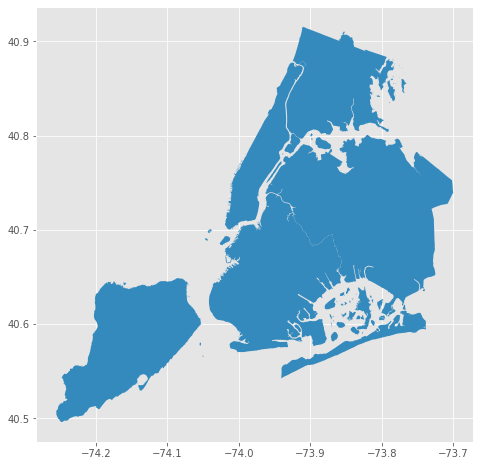

In [152]:
NYC_map = gpd.read_file('/content/drive/MyDrive/FDS data/geo_export_7153a758-59c2-4ed3-880f-e2f2fd4330cc.shp')
NYC_map.to_crs(epsg=4326).plot(figsize=(8,8))

#### 2. Plotting the NYC Gun violence Map for all the 15 years (2006-2020)

Text(0.5, 1.0, 'NY Gun violence Map for NYC')

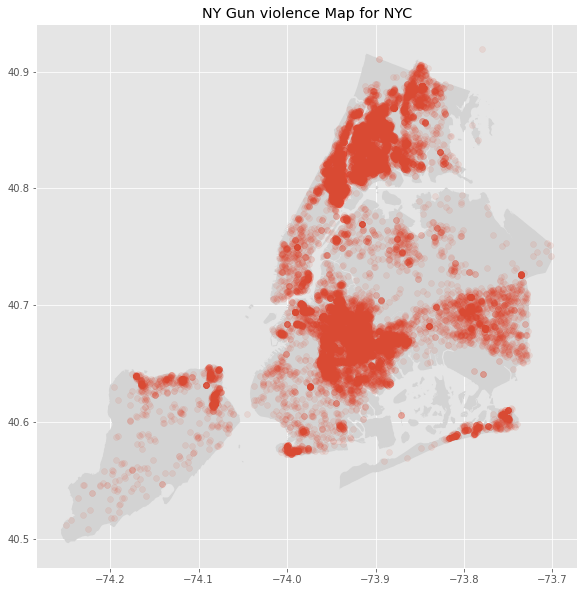

In [153]:
fig, ax = plt.subplots(figsize = (10,10))
NYC_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
purified_dataset.plot(ax=ax, alpha = .1 )
ax.set_title('NY Gun violence Map for NYC')

#### 3. Checking the the boroughs where the max gun crimes happened since 15 years

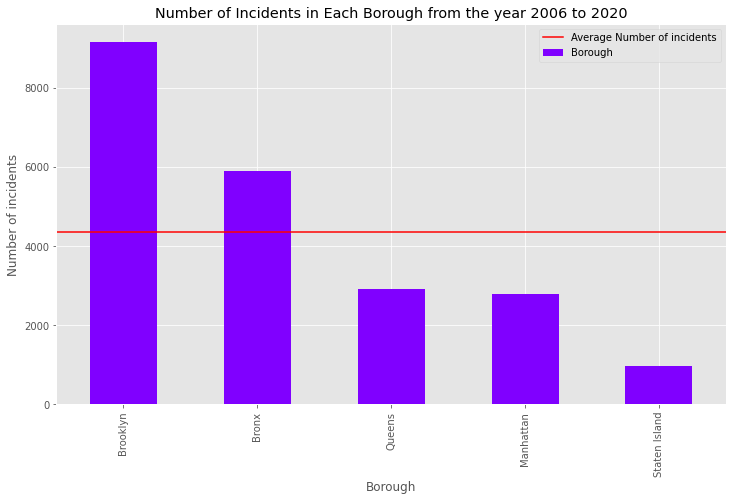

In [154]:
plot = purified_dataset['Borough'].value_counts().plot(kind='bar', title="Number of Incidents in Each Borough from the year 2006 to 2020", figsize=(12,7), colormap='rainbow')
plot.set_xlabel('Borough')
plot.set_ylabel('Number of incidents')
mean_line = plot.axhline(purified_dataset['Borough'].value_counts().mean(), color='r',label='Average Number of incidents')
plt.legend()

#### 4. Checking average gun crime in past 14 years with respect to  the day in a week (x axis) and month in a year(y axis) 

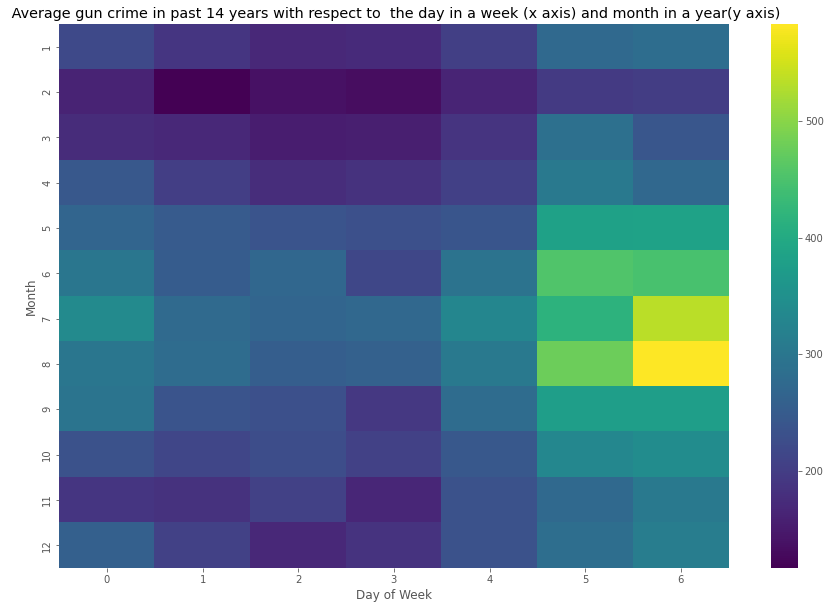

In [155]:
purified_dataset['id']=[i for i in range(purified_dataset.shape[0])]
plt.style.use('ggplot')
days_of_week_grouped_by_incident=purified_dataset.groupby(["Month","Day of Week"])['id'].count().unstack()
plt.figure(figsize=(15,10))
plt.title(" Average gun crime in past 14 years with respect to  the day in a week (x axis) and month in a year(y axis)")
sns.heatmap(days_of_week_grouped_by_incident,cmap='viridis')


#### 5. Viewing the crime rate by timeline

We will do this with respect to both the datasets separately. (NOT THE CLUBBED DATASET)

In [156]:
purified_dataset=purified_dataset.sort_values(['Year', 'Month', 'Day of Week']).reset_index()
del(purified_dataset['index'])

Text(0.5, 1.0, 'Crime in NYC from 2006 to 2019 Year wise')

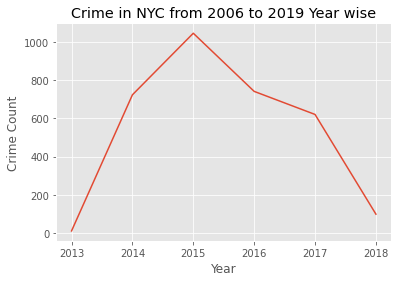

In [157]:
CrimeByYear=pd.DataFrame(data_1['Year'].value_counts()).sort_index()
plt.plot(CrimeByYear.index, CrimeByYear['Year'])
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Crime in NYC from 2006 to 2019 Year wise')

Text(0.5, 1.0, 'Gun violence incidents in NYC from 2006 to 2020')

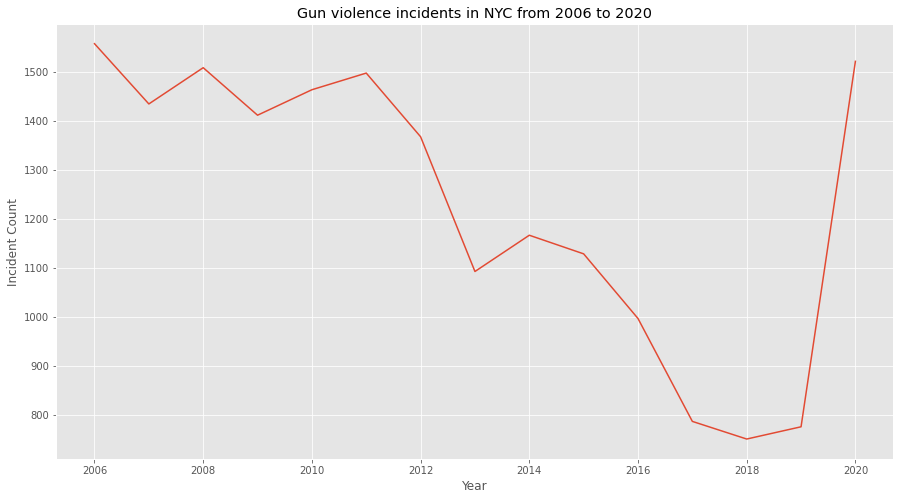

In [158]:
CrimeByYear=pd.DataFrame(data_2['Year'].value_counts()).sort_index()
plt.figure(figsize=(15, 8))
plt.plot(CrimeByYear.index, CrimeByYear['Year'])
plt.xlabel('Year')
plt.ylabel('Incident Count')
plt.title('Gun violence incidents in NYC from 2006 to 2020')

In [159]:
#plotting the data on Map Yearwise
def yearWisePlots(df, Year):
  df=df.loc[df['Year']==Year]
  fig, ax = plt.subplots(figsize = (10,10))
  NYC_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
  df.plot(ax=ax, alpha = .1 )
  ax.set_title('NY Gun violence Map for NYC for the year:'+str(Year))

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


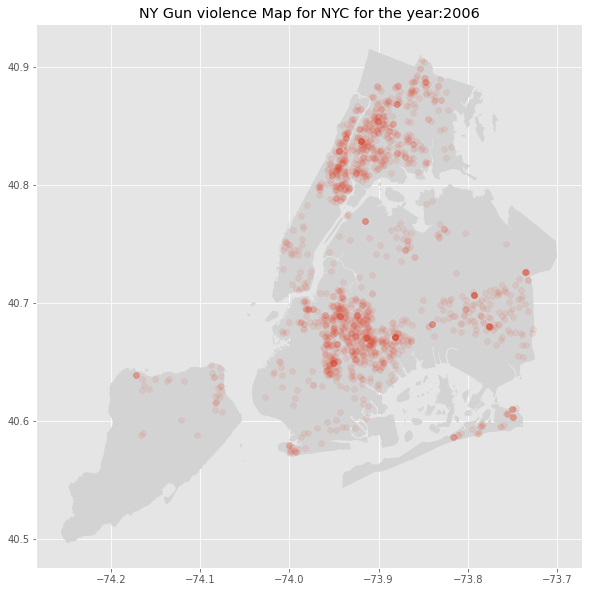

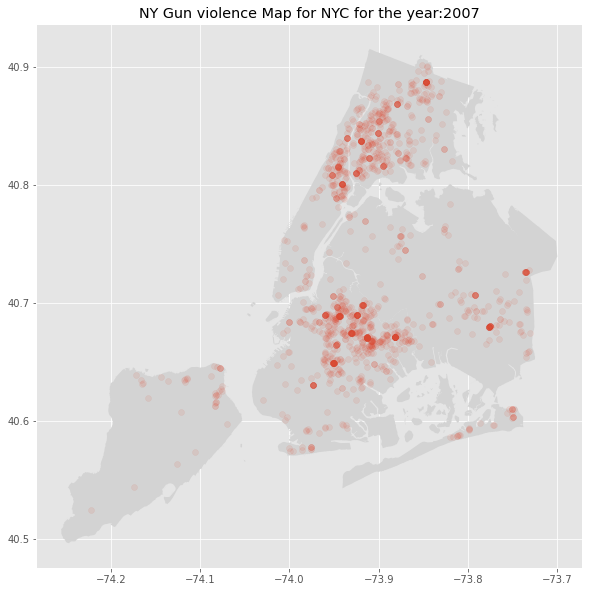

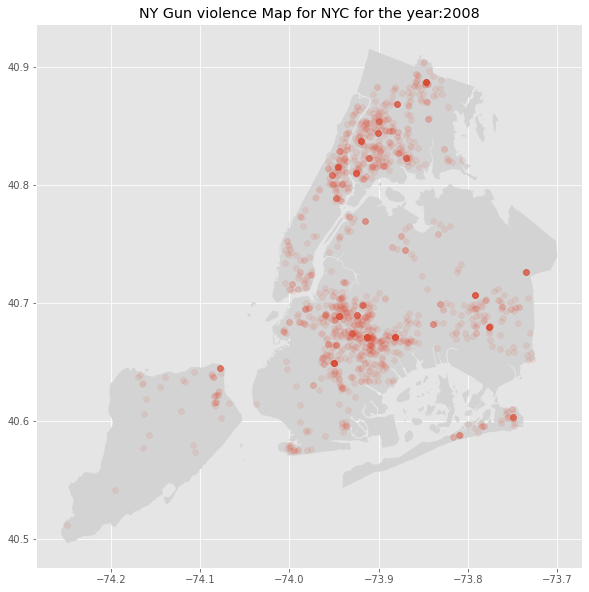

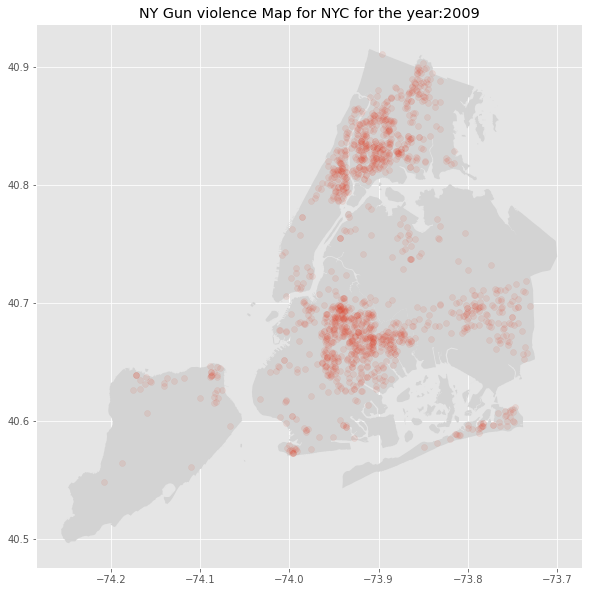

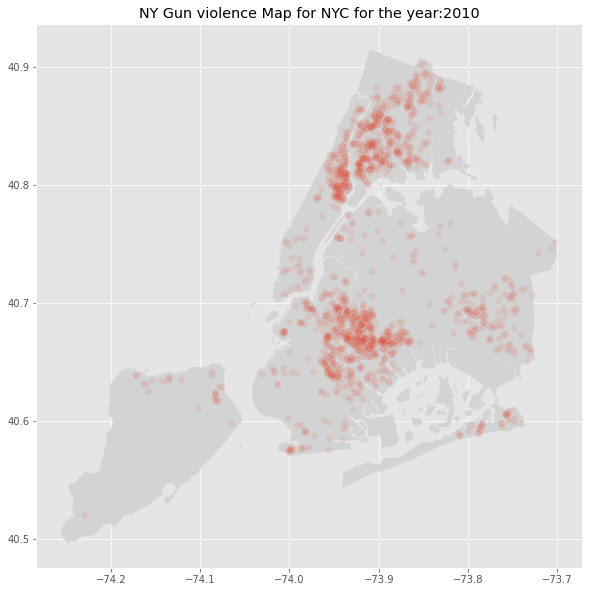

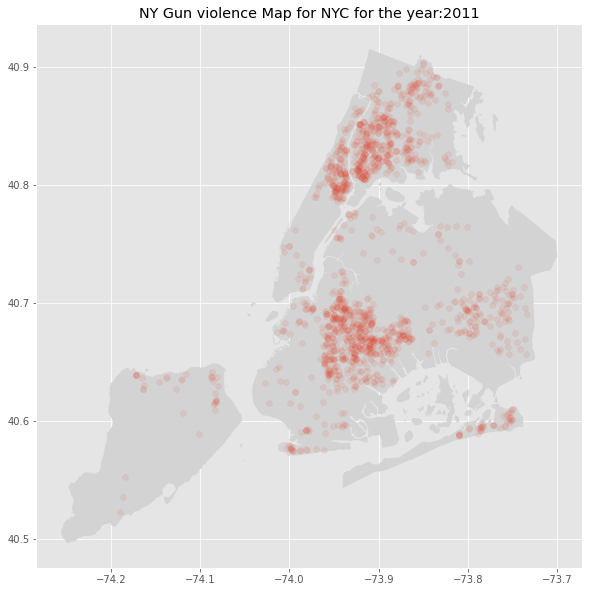

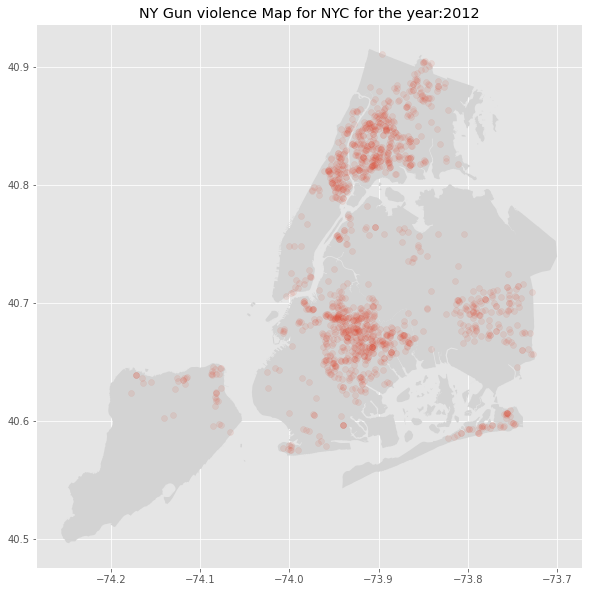

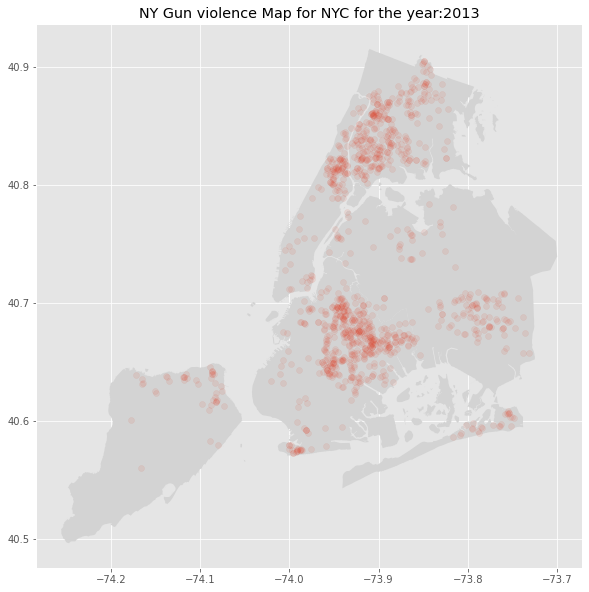

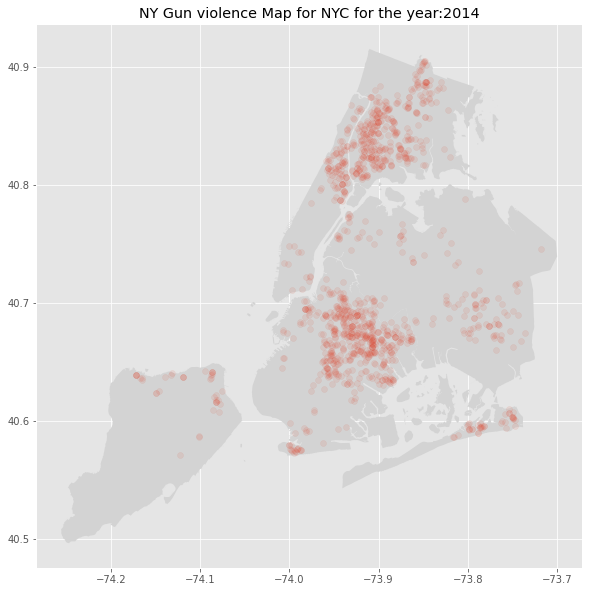

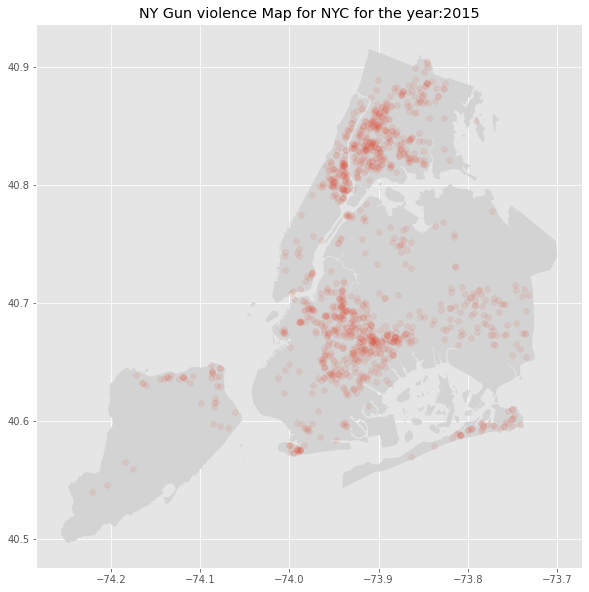

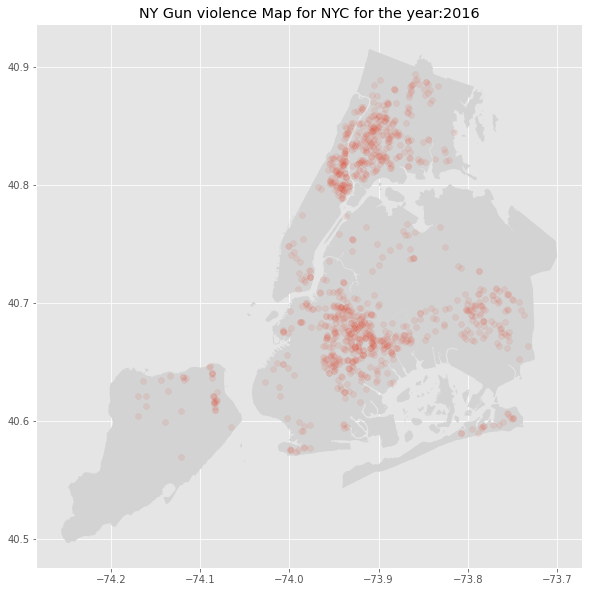

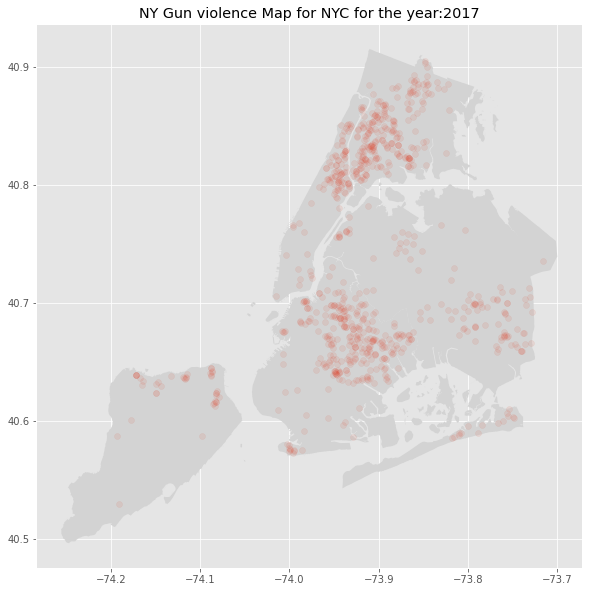

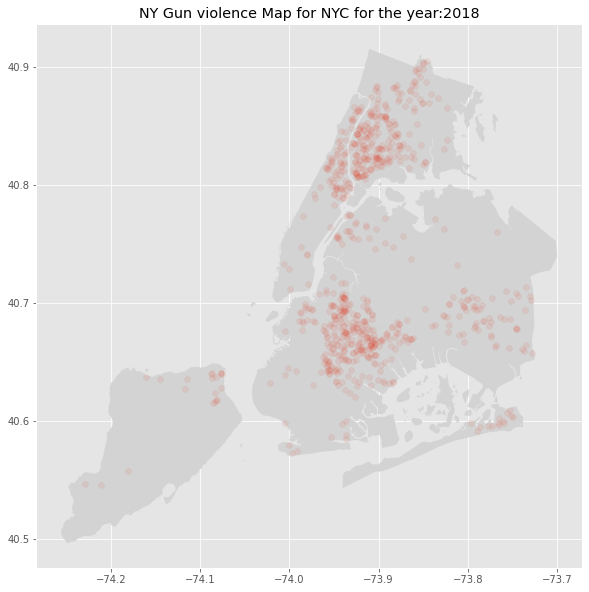

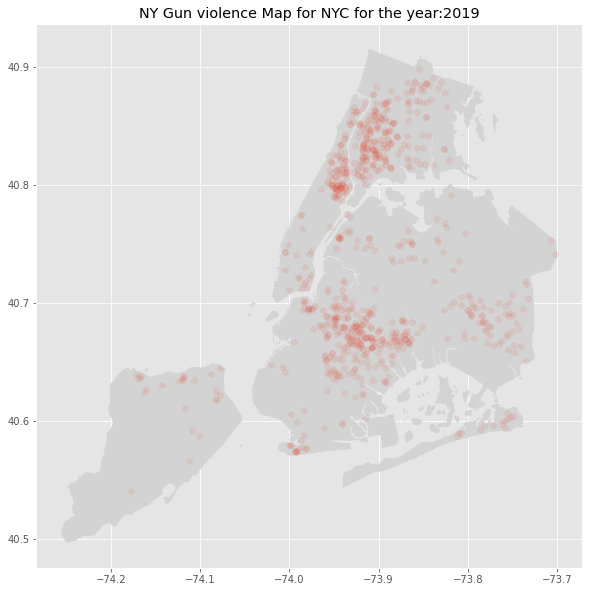

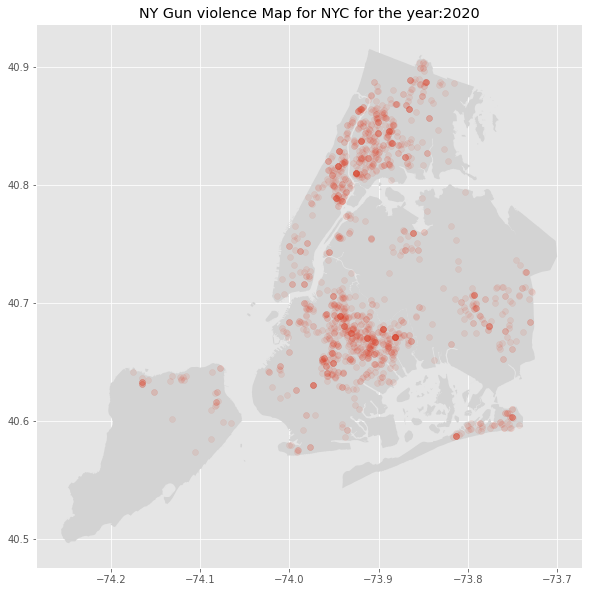

In [160]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(data_2['Longitude'], data_2['Latitude'])]
data_2 = gpd.GeoDataFrame(data_2, crs = crs, geometry = geometry)

for year in range(2006, 2021):
  yearWisePlots(data_2, year)

In [161]:
import libpysal
from sklearn.cluster import KMeans, AgglomerativeClustering

#### A. For clustering with respect to the locations, we can use first three variables (Latitude, Longitude, Boroughs).

Here, we use two types of clustering models.

      1. K-Means
      2. Agglomerative Clustering

But, for K-Means clustering, we need to decide the number of clusters. For that, we will use the Elbow method.  

In [162]:
clustering_data=purified_dataset.iloc[:, :-2]
clustering_data.loc[clustering_data['Borough']=='Brooklyn', 'Borough'] = 1
clustering_data.loc[clustering_data['Borough']=='Bronx', 'Borough'] = 2
clustering_data.loc[clustering_data['Borough']=='Queens', 'Borough'] = 3
clustering_data.loc[clustering_data['Borough']=='Manhattan', 'Borough'] = 4
clustering_data.loc[clustering_data['Borough']=='Staten Island', 'Borough'] = 5

lats=clustering_data['Latitude']
longs=clustering_data['Longitude']
boros=clustering_data['Borough']

clustering_data_elbow = np.array(list(zip(lats, longs, boros))).reshape(len(boros), 3) 

distorts = [] 
inertias = [] 
(map1,map2) = ({},{}) 
KRange = 20

for k in range(1, KRange): 
    kMeansClusteringModel=KMeans(n_clusters=k)
    kMeansClusteringModel.fit(clustering_data_elbow)
    distorts.append(sum(np.min(cdist(clustering_data_elbow, kMeansClusteringModel.cluster_centers_,'euclidean'),axis=1))/clustering_data_elbow.shape[0]) 
    inertias.append(kMeansClusteringModel.inertia_)
    map1[k]=sum(np.min(cdist(clustering_data_elbow, kMeansClusteringModel.cluster_centers_,'euclidean'),axis=1))/clustering_data_elbow.shape[0] 
    map2[k]=kMeansClusteringModel.inertia_

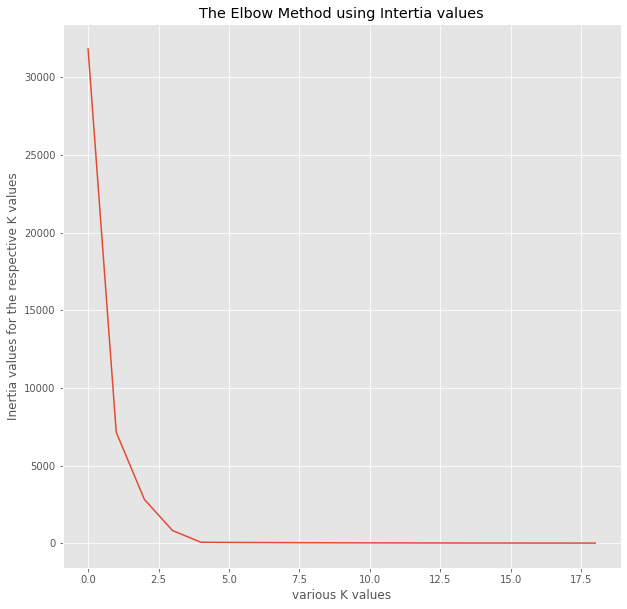

In [163]:
plt.figure(figsize=(10, 10))
plt.xlabel('various K values')
plt.ylabel('Inertia values for the respective K values') 
plt.title('The Elbow Method using Intertia values') 
plt.plot(inertias)
plt.show()

### Now Clustering the data using K-Means and Agglomerative Clustering

In [181]:
def kMeansClustering(K, df):
    model=KMeans(n_clusters=K, random_state=0).fit(df)
    centers=model.cluster_centers_
    labels = pd.Series(model.labels_, name='label')
    #datapoints with clusterlabel
    gun_violence_clusters = df.join(labels.to_frame())
    #centroids
    gun_violence_cluster_centroids = pd.DataFrame(centers, columns=["Latitude_Centroid","Longitude_Centroid", "Borough_centroid"])
    gun_violence_clusters["label"].value_counts().sort_index()

    #setup centroids first
    gdf_centroids=gpd.GeoDataFrame(geometry=gpd.points_from_xy(gun_violence_cluster_centroids['Longitude_Centroid'], gun_violence_cluster_centroids['Latitude_Centroid'], gun_violence_cluster_centroids['Borough_centroid']))

    #setup the data points in the clusters corresponding to the respective centroids
    gdf=gpd.GeoDataFrame(gun_violence_clusters, geometry=gpd.points_from_xy(gun_violence_clusters['Longitude'], gun_violence_clusters['Latitude']))
        
    fig, ax = plt.subplots(figsize=(10,10))
    #plot 
    NYC_map.plot(ax = ax, edgecolor='black', color='white')   
    gdf.plot(markersize=8, alpha=0.8, ax=ax, column='label')
    ax.set_title("Clustering Gun Violence by using K-Means Algorithm")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    gdf_centroids.plot(ax=ax, color='red', alpha = 1, marker = '*', markersize=60)

    plt.show()

def agglomerativeClustering(K, df):
    model = AgglomerativeClustering(n_clusters=K, affinity="euclidean", linkage="complete")
    model = model.fit(df)

    labels = pd.Series(model.labels_, name='label')
    gun_violence_clusters = df.join(labels.to_frame())
    gun_violence_clusters["label"].value_counts().sort_index()

    gdf=gpd.GeoDataFrame(gun_violence_clusters,
        geometry=gpd.points_from_xy(gun_violence_clusters['Longitude'], gun_violence_clusters['Latitude']))
        
    fig, ax = plt.subplots(figsize=(10,10))
    NYC_map.plot(ax = ax, edgecolor='black', color='white')
    ax.set_title("Clustering Gun Violence by using Agglomerative Clustering Algorithm") 
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    gdf.plot(markersize=8, alpha=0.8, ax=ax, column='label')    
    plt.show()


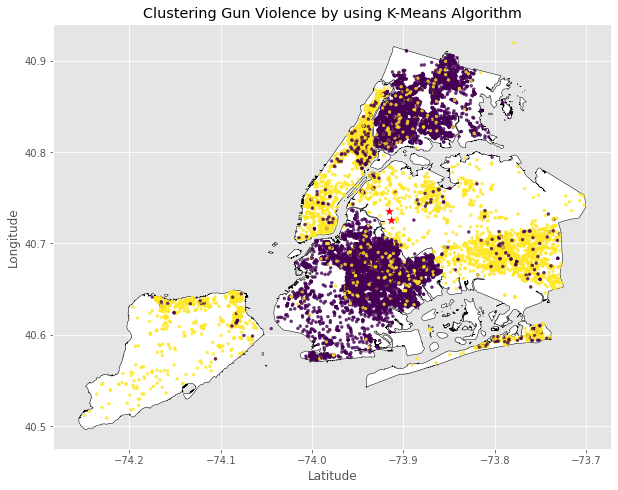

In [178]:
clustering_data=purified_dataset.iloc[:, :3]

clustering_data.loc[clustering_data['Borough']=='Brooklyn', 'Borough'] = 1
clustering_data.loc[clustering_data['Borough']=='Bronx', 'Borough'] = 2
clustering_data.loc[clustering_data['Borough']=='Queens', 'Borough'] = 3
clustering_data.loc[clustering_data['Borough']=='Manhattan', 'Borough'] = 4
clustering_data.loc[clustering_data['Borough']=='Staten Island', 'Borough'] = 5

kMeansClustering(2, clustering_data)

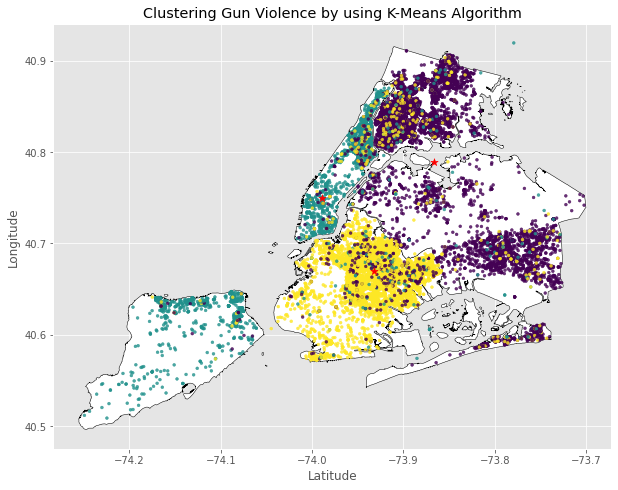

In [179]:
kMeansClustering(3, clustering_data)

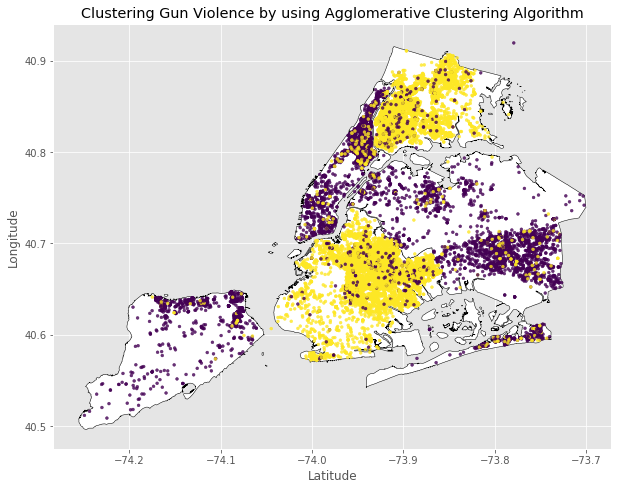

In [182]:
agglomerativeClustering(2, clustering_data)

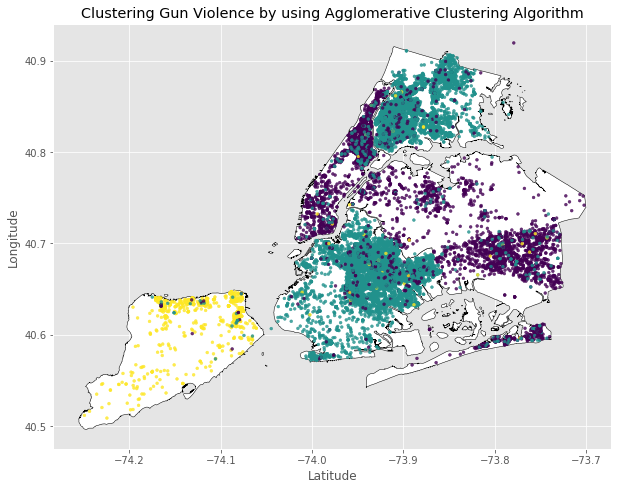

In [168]:
agglomerativeClustering(3, clustering_data)

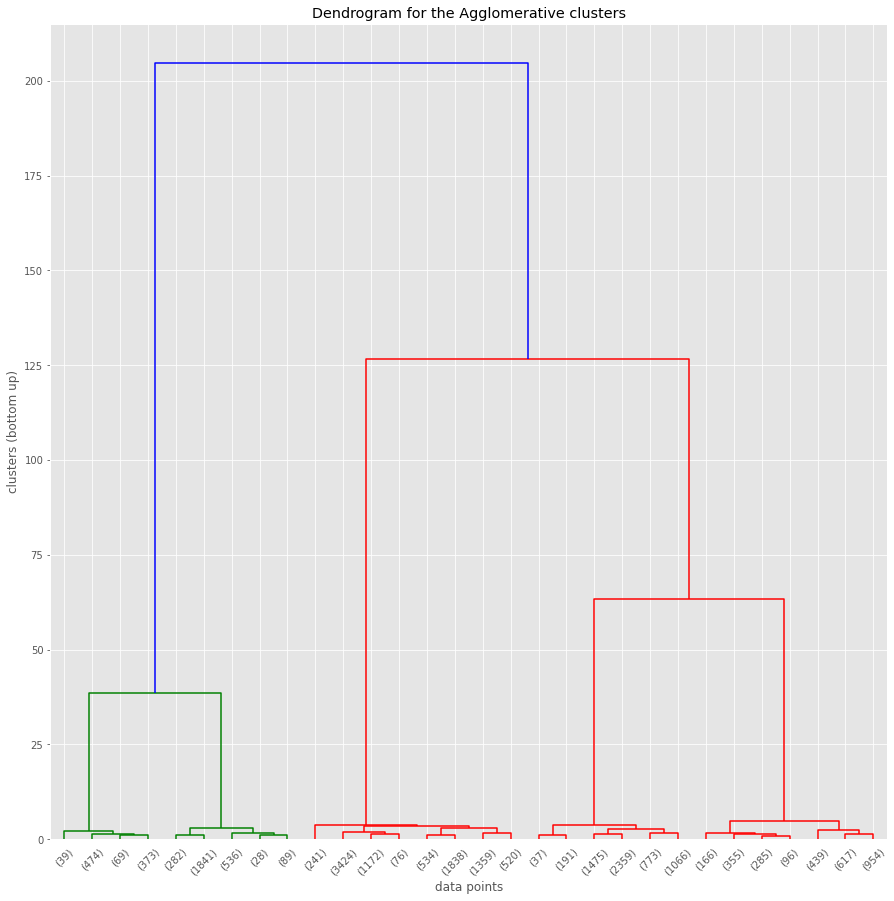

In [191]:
plt.figure(figsize=(15, 15))
plt.title("Dendrogram for the Agglomerative clusters")
plt.xlabel("data points")
plt.ylabel("clusters (bottom up)")
dendrog=shc.dendrogram(shc.linkage(clustering_data, method='ward'), truncate_mode='lastp')

In [186]:
clustering_data.head()

,Latitude,Longitude,Borough
0,40.647258,-73.955695,1
1,40.637769,-74.076481,5
2,40.710989,-73.942949,1
3,40.885358,-73.850159,2
4,40.638988,-74.007727,1


# 2. Now, Working with "time" 

Analysis using second dataset as the first dataset doesnt contain "time" attribute

In [203]:
def getWantedDatasetwithTime(year, month, day_of_week, lat, lon, nVictims, borough, time):
    df=pd.DataFrame()
    df['Latitude']=lat
    df['Longitude']=lon
    df['Borough']=borough
    df['Month']=month
    df['Year']=year
    df['Number of Victims']=nVictims
    df['Day of Week']=day_of_week
    df['hour']=time
    return df

# ANALYSIS WITH RESPECT TO SEASONS

Spring: March, April, May 

Summer: June, July, August

Fall: September, October, November

Winter: December, January, February

In [242]:
sorted_df2['OCCUR_TIME_CONVERTED']=[parser.parse(i) for i in sorted_df2['OCCUR_TIME']]
sorted_df2["hour"]=sorted_df2["OCCUR_TIME_CONVERTED"].apply(lambda time:time.hour)
del(sorted_df2['OCCUR_TIME_CONVERTED'])
del(sorted_df2['OCCUR_TIME'])
data_2_with_time=getWantedDatasetwithTime(sorted_df2['Year'], sorted_df2['Month'], sorted_df2['Day_of_Week'], sorted_df2['Latitude'], sorted_df2['Longitude'], sorted_df2['nVictims'], sorted_df2['BORO'], sorted_df2["hour"])
data_2_with_time.head()

,Latitude,Longitude,Borough,Month,Year,Number of Victims,Day of Week,hour
11680,40.807699,-73.947385,MANHATTAN,1,2006,1,6,2
18688,40.835990,-73.916276,BRONX,1,2006,1,6,5
11775,40.672153,-73.956050,BROOKLYN,1,2006,1,6,12
21364,40.857771,-73.894606,BRONX,1,2006,1,6,2
20951,40.651014,-73.945707,BROOKLYN,1,2006,1,6,3


In [243]:
summer_data=data_2_with_time.loc[(data_2_with_time['Month']==3) | (data_2_with_time['Month']==4) | (data_2_with_time['Month']==5)]
fall_data=data_2_with_time.loc[(data_2_with_time['Month']==6) | (data_2_with_time['Month']==7) | (data_2_with_time['Month']==8)]
winter_data=data_2_with_time.loc[(data_2_with_time['Month']==9) | (data_2_with_time['Month']==10) | (data_2_with_time['Month']==11)]
spring_data=data_2_with_time.loc[(data_2_with_time['Month']==12) | (data_2_with_time['Month']==1) | (data_2_with_time['Month']==2)]

### Now, In each season, analysing the gun violence incidents based on hours in a day

We can see that Fall, Summer predominates in number of incidents and it co-incides with the heatmap that was shown before.

In [268]:
def getGunViolenceDataByHour(data_2_with_time, timeframe, Seasons=False):
  temp=pd.DataFrame(data_2_with_time['hour'].value_counts())
  hour=temp['hour']
  avg=hour/sum(hour)
  temp['hour']=avg

  if Seasons==False:
    plt.figure(figsize=(15, 10))
    plt.title("Average gun violance incidents in a day of NYC based on hour in "+timeframe)
    plt.xlabel("Hours")
    plt.ylabel("Average Gun violence incidents")
    plt.bar(temp.index, temp['hour'], width=0.4, color='b')
  return temp

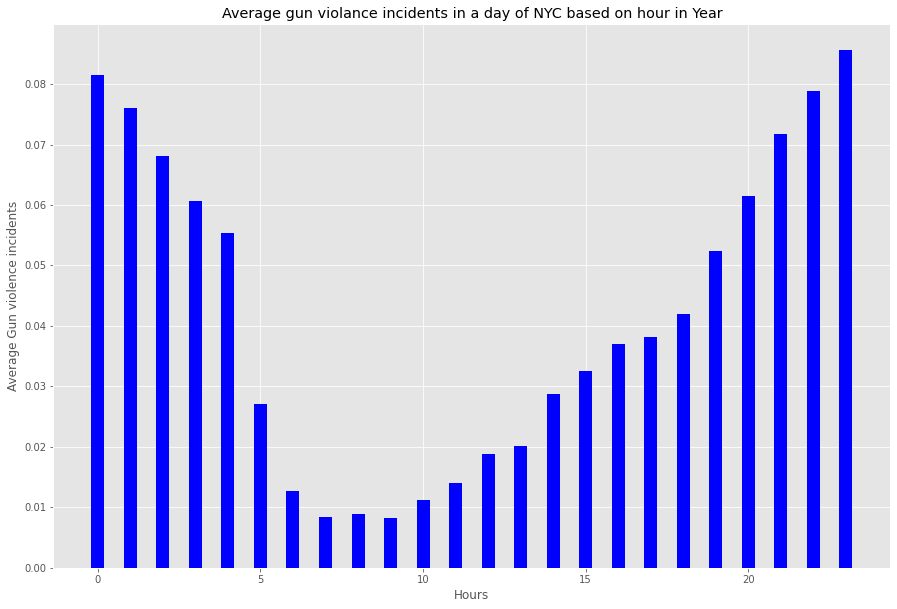

In [269]:
getGunViolenceDataByHour(data_2_with_time, "Year", False)
summer=getGunViolenceDataByHour(summer_data, "SUMMER", True)
fall=getGunViolenceDataByHour(fall_data, "FALL", True)
winter=getGunViolenceDataByHour(winter_data, "WINTER", True)
spring=getGunViolenceDataByHour(spring_data, "SPRING", True)

No handles with labels found to put in legend.


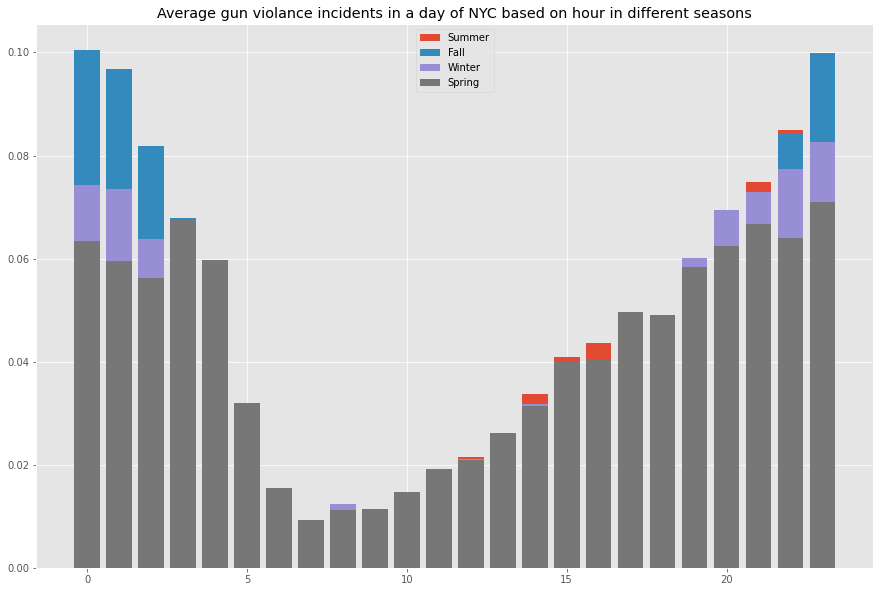

In [270]:
plt.figure(figsize=(15, 10))
bar1=plt.bar(summer.index, summer['hour'])
bar2=plt.bar(fall.index, fall['hour'])
bar3=plt.bar(winter.index, winter['hour'])
bar4=plt.bar(spring.index, spring['hour'])
plt.legend()
plt.title("Average gun violance incidents in a day of NYC based on hour in different seasons")
plt.legend( (bar1, bar2, bar3, bar4), ('Summer', 'Fall', 'Winter', 'Spring') )

### Average Number of Incidents based on Seasons

<BarContainer object of 4 artists>

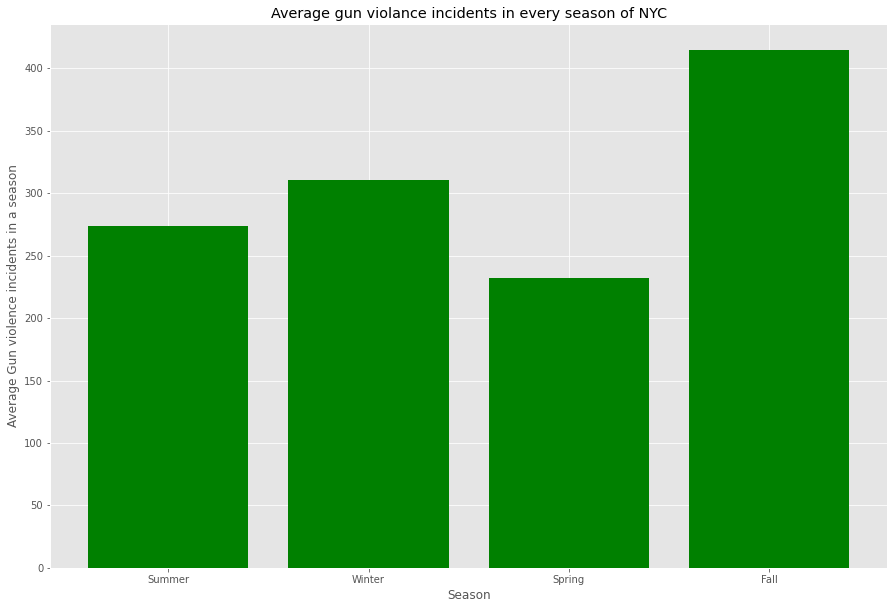

In [274]:
plt.figure(figsize=(15, 10))
plt.title("Average gun violance incidents in every season of NYC")
plt.xlabel("Season")
plt.ylabel("Average Gun violence incidents in a season")
plt.bar(["Summer","Winter","Spring","Fall"], [summer_data.shape[0]/15, winter_data.shape[0]/15, spring_data.shape[0]/15, fall_data.shape[0]/15], color="g")